## Word Embeddings
* An embedding maps discrete, categorical values to a continous space.
* Words within the same location have the similiar/semantic meaning.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
%matplotlib inline

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [3]:
text = "the quick brown fox jumps over the lazy dog"

In [4]:
def vocab2idx(a):
  vocab2idx = {}
  text = a.split(' ')
  vocab = set(text)
  for i,word in enumerate(vocab):
    vocab2idx[word] = i
  return vocab2idx

In [5]:
token2idx = vocab2idx(text)
idx2token = {token:word for word,token in token2idx.items()}
vocab_size = len(token2idx)

In [6]:
def convert2int(text,token2idx):
  text = text.split(' ')
  tokens = [token2idx[word] for word in text]
  return tokens

In [7]:
tokens = convert2int(text,token2idx)
tokens = torch.tensor(tokens)
tokens

tensor([2, 5, 0, 3, 7, 1, 2, 4, 6])

In [8]:
embedding = nn.Embedding(vocab_size,3)
out = embedding(tokens)
print(out,out.shape)

tensor([[-0.8817,  0.6176, -0.4646],
        [-0.7545, -0.3889,  0.4914],
        [-0.4092,  0.1777, -0.8619],
        [ 0.3895,  0.3403,  1.6206],
        [-0.6223,  0.0088, -0.0897],
        [ 0.6188,  1.0530,  0.5260],
        [-0.8817,  0.6176, -0.4646],
        [-1.1419,  0.8132,  1.7498],
        [-2.6799,  1.0546, -2.2106]], grad_fn=<EmbeddingBackward>) torch.Size([9, 3])


## Using Globe Embedding and checking the similarity of words

In [9]:
# Used a api of globe for faster access
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt \
    -O /tmp/glove.6B.100d.txt
embeddings_index = {};
with open('/tmp/glove.6B.100d.txt') as f:
    for line in f:
        values = line.split();
        word = values[0];
        coefs = np.asarray(values[1:], dtype='float32');
        embeddings_index[word] = coefs;

--2020-07-29 13:18:54--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.119.128, 108.177.126.128, 108.177.127.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.119.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 347116733 (331M) [text/plain]
Saving to: ‘/tmp/glove.6B.100d.txt’

/tmp/glove.6B.100d. 100%[===================>] 331.04M   240MB/s    in 1.4s    

2020-07-29 13:18:56 (240 MB/s) - ‘/tmp/glove.6B.100d.txt’ saved [347116733/347116733]



In [10]:
glove_embeddings = np.array([embeddings_index[word] for word in text.split()])

In [11]:
glove_embeddings.shape

# As there are 9 words of it is embedding of 100d

(9, 100)

## Similarity operations on embeddings
#### Finiding the similarity in different words of the same content

In [12]:
def get_similarity(word1,word2):
  x = embeddings_index[word1]
  y = embeddings_index[word2]
  sim = cosine_similarity([x],[y])
  print("Similarity between 2 vectors: ",sim[0][0])

In [13]:
get_similarity('cat','dog')

Similarity between 2 vectors:  0.8798075


In [14]:
get_similarity('king','queen')

Similarity between 2 vectors:  0.7507691


In [15]:
get_similarity('tree','leaf')

Similarity between 2 vectors:  0.6364573


## Visualizing Embeddings
#### We can use an algorithm called t-SNE to project the high dimentional word embeddings to a lower dimension in order to plot them in 2-D.


In [16]:
ANIMALS = [
    'whale',
    'fish',
    'horse',
    'rabbit',
    'sheep',
    'lion',
    'dog',
    'cat',
    'tiger',
    'hamster',
    'pig',
    'goat',
    'lizard',
    'elephant',
    'giraffe',
    'hippo',
    'zebra',
]


HOUSEHOLD_OBJECTS = [
    'stapler',
    'screw',
    'nail',
    'tv',
    'dresser',
    'keyboard',
    'hairdryer',
    'couch',
    'sofa',
    'lamp',
    'chair',
    'desk',
    'pen',
    'pencil',
    'table',
    'sock',
    'floor',
    'wall',
]

In [17]:
embed = np.array([embeddings_index[word] for word in ANIMALS+HOUSEHOLD_OBJECTS])
embed.shape

(35, 100)

In [18]:
tsne_words_embedded = TSNE(n_components=2).fit_transform(embed)
tsne_words_embedded.shape

(35, 2)

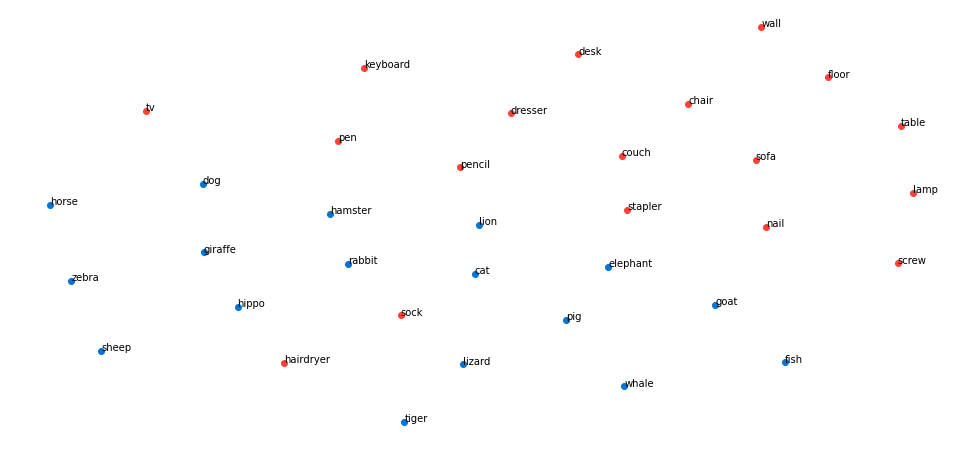

In [19]:
x, y = zip(*tsne_words_embedded)

fig, ax = plt.subplots(figsize=(17, 8))

for i, label in enumerate(ANIMALS + HOUSEHOLD_OBJECTS):
    if label in ANIMALS:
        color = '#0074D9'
    elif label in HOUSEHOLD_OBJECTS:
        color = '#FF4136'
        
    ax.scatter(x[i], y[i], c=color)
    ax.annotate(label, (x[i], y[i]))

ax.axis('off')

plt.show()

Similar words are grouped together

##  Context embeddings
GloVe and Fasttext are two examples of global embeddings, where the embeddings don't change even though the "sense" of the word might change given the context. This can be a problem for cases such as:

A mouse stole some cheese.
I bought a new mouse the other day for my computer.


The word mouse can mean both an animal and a computer accessory depending on the context, yet for GloVe they would receive the same exact distributed representation. We can combat this by taking into account the surroudning words to create a context-sensitive embedding. Context embeddings such as Bert are used for this case